## Astro 304 "Galaxies"

### Homework 2 (due Friday, Apr 21, 7pm)

<b>30 points</b> 

You should make your homework available to me by the due date/time as an IPython (Jupyter) notebook via a github repository. I encourage you to discuss your work with others, but actual calculations and plots should be your own. All the data required for these exercises can be found in the data/ subdirectory at the same link as before. 

<b>1) (15 points). Luminosity functions of galaxies as a function of morphological type.</b><br> (a) Use example code below (a simplified version of the code in <tt>ex02</tt> notebook) that shows how to estimate galaxy luminosity function of the SDSS galaxies in the UPenn catalog using the $1/V_{\rm max}$ method to calculate and plot luminosity functions of galaxies of 4 different morphological types - Ell, S0, Sab, Scd - using the Sersic model luminosities and morphological class probabilities from the <a href="http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M">Meert et al. (2015)</a> catalog. Plot the LFs for individual morphological classes along with the LF for the entire galaxy sample. Discuss luminosity distributions of galaxies of different morphologies and how they differ from each other. What are the most salient trends? (10 points)<br> 
(b) Use the image thumbnail tools you now have to look at the appearance of galaxies in different luminosity bins. Present rows of randomly selected $\sim 10$ galaxy images in luminosity bins of increasing luminosity. (5 points)
<br>

<b>2) (5 points).Stellar mass function of bright galaxies</b>. Construct the stellar mass function -- analogue of luminosity function but were stellar mass is used instead of luminosities - for galaxies from the UPenn photometry catalog. Use the same Meert et al. catalog the way it was used to compute the luminosity function, but now convert $r$-band luminosities to stellar masses using galaxy $g-r$ color and construct stellar mass function: i.e., number density of galaxies as a function of stellar mass. To convert luminosities to stellar mass use stellar mass-to-light ratio calibrated using stellar population models by Bell et al. (2003): $\log_{10}(M_\star/L_r) = -0.306 + 1.097(g-r) - 0.1$, where $M_\star$ is in solar masses ($M_\odot$), $L_r$ is in $L_{\odot,r}$ and $-0.1$ corrects their calibration to a more conventional initial  mass function of stars (IMF). You can see how well this relation fits actual stellar population synthesis calculations in the <tt>ex03</tt> notebook in the repository.  


<b>3) (10 points) Stellar mass function of low-luminosity galaxies.</b> Use the <a href="http://www.gama-survey.org/dr2/">GAMA galaxy DR2 survey catalog</a> The fits file <tt>GAMA_DR2_master.fits</tt> is in the data/ subdirectory in the usual site.  Estimate stellar mass function of galaxies for the GAMA survey. The code snippet below shows you how to read the relevant data. 
Estimate of stellar mass is available in the GAMA catalog itself for each galaxy and its 10-base logarithm is given by variable <tt>logmstar</tt>.
This catalog probes relatively nearby universe ($z<0.06$) and its spectroscopic sample is deeper than SDSS by about two magnitudes. The apparent magnitude limit of the survey in the $r$ band is $m_{r,\rm lim}=19.4$ - i.e., almost 2 magnitudes deeper than SDSS. Thus it is more suitable for measuring luminosity and stellar mass function at faint luminosities (so-called "dwarf" galaxies). You can read more about the survey and measurements of stellar mass function for its galaxies in <a href="">Baldry et al. (2012)</a>. The code snippet below applies the same cuts to define the sample as in that study. The total survey area for the data in the file is 144 square degrees and it is 98% complete for $m_r\leq 19.4$ (7 points).

Compare the stellar mass function from GAMA to that you get from the Meert et al. photometry for the SDSS. Construct composite stellar mass function from the Meert et al. (2015) catalog (better at bright luminosities) and from the GAMA survey (better at the faint end) by taking the maximum of the two at each luminosity bin. Be careful to use the same units and h-scalings for both UPenn and GAMA stellar mass functions (3 points). We will be using the composite stellar mass function you construct later in the course to quantify relation between galaxy stellar mass and mass of its parent dark matter-dominated halo and to test galaxy formation model we will build. 

In [1]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('WMAP9')

# code computing luminosity function and its errors using bootsrap resampling
def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)

    if you are not familiar with bootstrap, see e.g. here: 
    https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf

    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))


In [2]:
# now read the Upenn catalog and apply selection cuts to galaxies 
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sdata['z'] < z_max) & 
        (sb50 > 0.) & (sb50 <= 23.5) & (grm>-0.5) & (grm<2.2))
# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print "selected", np.size(zm), " after all cuts..."

670722 galaxies in Meert et al. sample initially
selected 244854  after all cuts...


In [3]:
# code to compute luminosity function of the SDSS galaxies in the SDSS catalog

# extract quantities useful for LF computation
zm = sdata['z']; 
# Petrosian magnitude from SDSS pipeline
mpetrom = phot_r['petroMag']; 
# apparent magnitude calculated by the UPenn group using Sersic profile fit 
# to light surface brightness profile and better estimate of the background light
mmeert = mdata['m_tot']
# r-band extinction and k-correction (latter provided in the catalog in this case)
extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


# inverse Vmax. In this catalog pre-computed Vmax is provided 
vmaxi = 1.0/vmaxm[ilim] 

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 


# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); 
Lpetrom = 0.4*(4.67-Mpetrom)

# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# compute 1/d_M^3
vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample.
#
# I couldn't find which of the two legacy samples Meert et al. (2015) used.
# One gives a sky fraction of 0.185, and the other 0.205. I'm assuming
# the below fraction was calculated as an average of these two?
solid_anglem = 0.195 * 4.*np.pi / 3
# compute final 1/Vmax for each galaxy
vmaxim = vmaxim / (solid_anglem*ccm)

C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


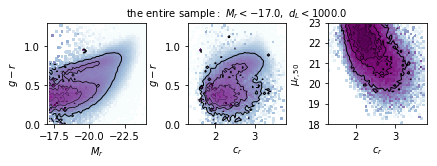

In [4]:
from code.plot_utils import plot_2d_dist

# select a sample of nearby SDSS galaxies down to a given luminosity to get reasonably detailed images
Mlim = -17.0; Dmax = 1000.
ipos = ((pEll<0) | (pS0<0) | (pSab<0) | (pScd<0))
iloc = (Mmeert < Mlim) & (20. < d_Lm) & (d_Lm < Dmax) & (pEll>=0) & (pS0>=0) & (pSab>=0) & (pScd>=0) 
grmloc = grm[iloc]; Mmloc  = Mmeert[iloc]; baloc = ba[iloc]
dLl = d_Lm[iloc]; vmaxiloc = vmaxi[iloc]
crloc = cr[iloc]; murloc= sb50[iloc]

Mrlim = [-24.,Mlim]; grlim = [0.,1.3];
crlim = [1.3,3.8]; sblim = [18., 23.]

clevs = np.linspace(0.2,0.95,4)

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

plot_2d_dist(Mmloc, grmloc, Mrlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(crloc, grmloc, crlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])

plot_2d_dist(crloc, murloc, crlim, sblim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])

#plt.savefig('fig/colconcmu_meert.png',bbox_inches='tight')
plt.show()
plt.close(fig)

# Problem 1. Sersic Luminosity Function

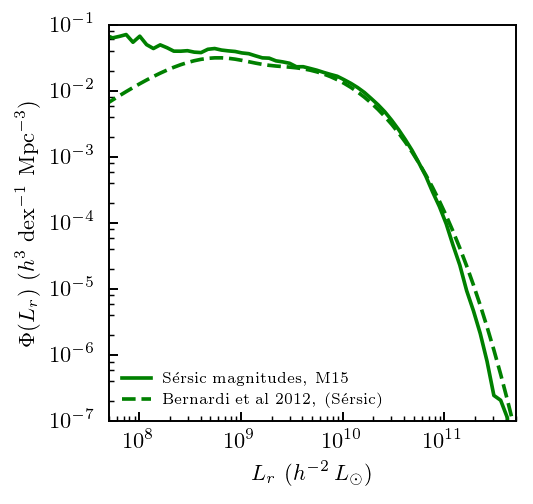

In [5]:
#
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 80 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
# define bin centers and log widths
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

# compute mean LF over a specified number of bootstrap resamplings along with error
phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
Lbinc = np.log10(10.**Lbinc*cosmo.h**2)

wEll = np.abs(pEll[iloc])*vmaxiloc; wS0 = pS0[iloc]*vmaxiloc; wSab = pSab[iloc]; wScd = pScd[iloc]
Mrlim = [-24,Mlim]

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Lbinc, phi_Lbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15}$')

#
# for comparison plot the best double Schechter function fit from Bernardi et al. (2013)
#
import math

ms = 10.**Lbinc*(0.73/0.7)**2/cosmo.h**2

# Sersic photometry LF parameters
mstarb = 0.0187e9; phisb = 1.343e-2; alphab = 1.678; betab = 0.3
phisg = 0.843e-2; mstarg = 0.8722e9; gammag = 1.058
gammanorm = math.gamma(alphab/betab)

# 0.7/0.73 factor below is to account for the difference in the assumed Hubble constant in Bernardi et al. 2013 and here
musb = ms/mstarb; musg = ms/mstarg
phiLB13_ser = (0.7/0.73)**3*np.log(10.)*(phisb*np.exp(-musb**betab)*musb**(alphab)*betab/gammanorm +
         phisg*musg**(gammag)*np.exp(-musg))


plt.plot(10.**Lbinc, phiLB13_ser/cosmo.h**3, '--', c='g', label=r'$\mathrm{Bernardi\ et\ al\ 2012,\ (S\acute{e}rsic)}$')

plt.legend(loc='lower left', fontsize=6, frameon=False)

#plt.grid()
plt.show()

## Problem 1b. LF bin collage

C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\axes\_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\h2_sf\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\axes\_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


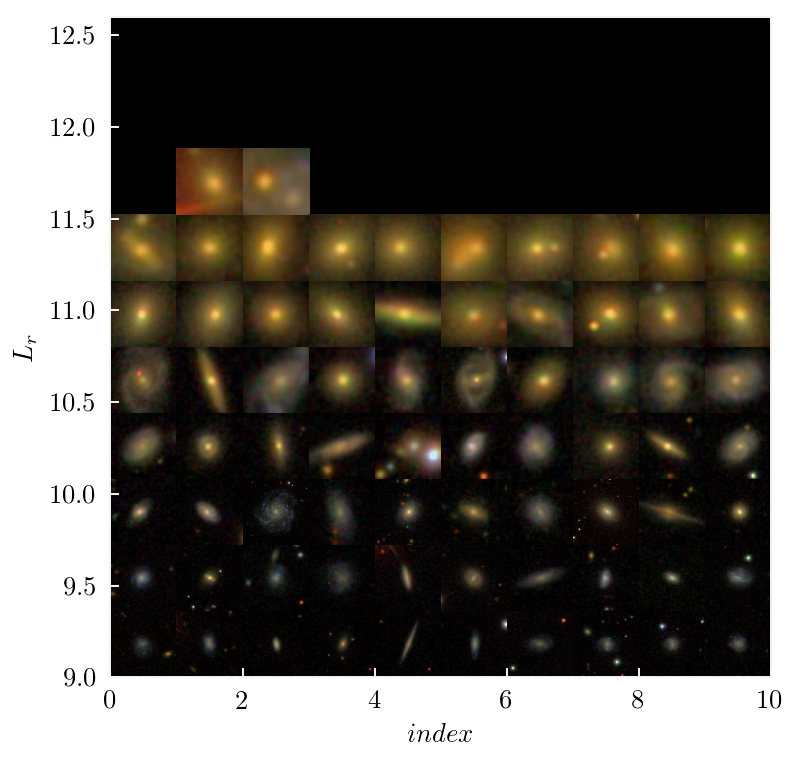

In [6]:
from code.plot_utils import plot_sdss_collage_with_2d_dist

# include code here to define indices of your selected galaxies

isel = (Lmeert > min(Lbinc)) & (Lmeert < max(Lbinc))

locdatas = sdata[isel]; locmdata = mdata[isel]
objs = locdatas['objid']; ras = locdatas['ra']; decs = locdatas['dec']
Lsel = Lmeert[isel]
d_A = d_Lm[isel]/np.square(1.0+locdatas['z'])

xlabel = r'$index$'; ylabel = r'$L_r$'
nrows = 10; ncols = 10; rnd_seed = 4647
xlims = [0.,ncols]; ylims = [9.,12.6]

xdummy = np.random.uniform(ncols,size=np.size(Lsel)) - 0.5

plot_sdss_collage_with_2d_dist(objs, ras, decs, 
                               xs=xdummy, ys=Lsel, 
                               xlims = xlims, ylims=ylims, xlab=xlabel, ylab=ylabel, 
                               show_axis=True, show_xaxis = True, show_yaxis=True, 
                               nrows=nrows, ncols=ncols, npix = 200, 
                               rnd_seed=rnd_seed, facecolor='black', kpc_per_npix = 30, dA = d_A)
#mpl.rc('axes',edgecolor='black');

In [7]:
galtypes = ['Ell', 'S0', 'Sab', 'Scd']
morphlim = 0.8
galtypeslices = {}
for m in galtypes:
    mkey = 'proba{0}'.format(m)
    resttypes = list(set(galtypes) - set([m]))
    restkeys = ['proba{0}'.format(o) for o in resttypes]
    morphslice = ( (morph[mkey] >= morphlim) & (morph[mkey] >= morph[restkeys[0]]) &
                   (morph[mkey] >= morph[restkeys[1]]) & (morph[mkey] >= morph[restkeys[2]])
                 )
    galtypeslices[m] = morphslice
    

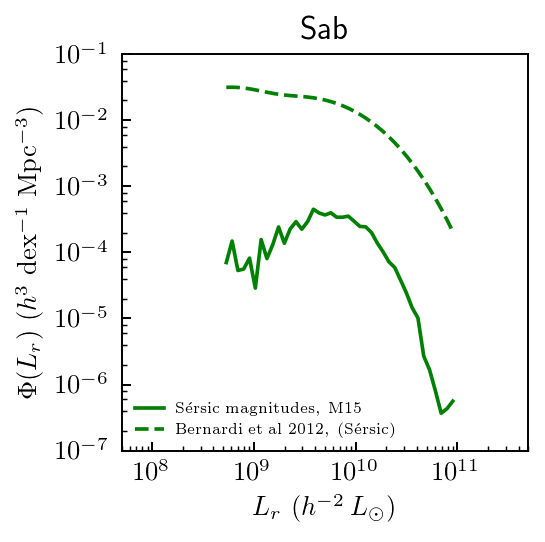

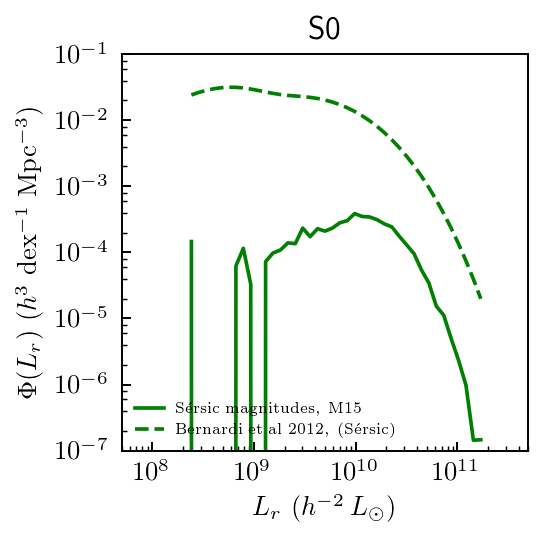

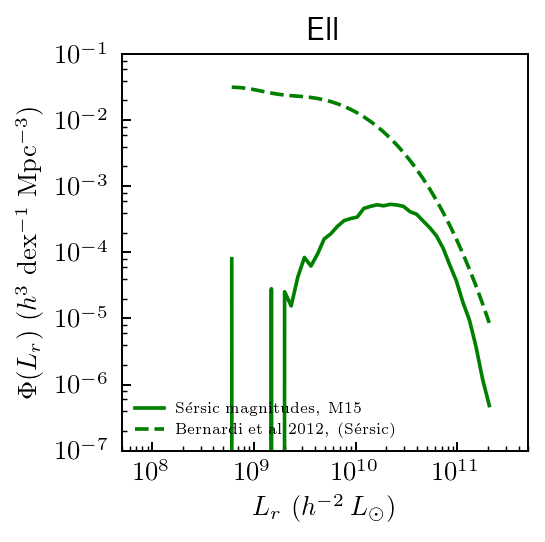

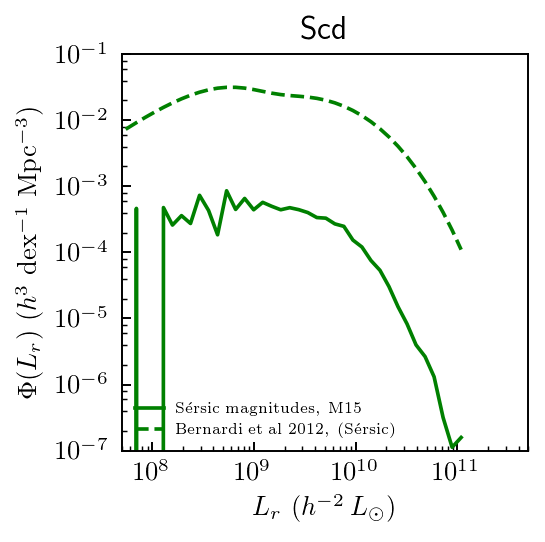

In [8]:
for galtype in galtypeslices:
    typeslice = galtypeslices[galtype]
    typeLmeert = Lmeert[typeslice]
    typevmaxim = vmaxim[typeslice]
    
    # compute luminosity function for all galaxies and bootstrap errors
    nbootstrap = 20; nbins = 40 # use nboostrap resamplings and estimate LF using nbins bins
    #first just get histogram without bootstrap to get bins 
    phi_Lmeert, Lbins = np.histogram(typeLmeert, weights=typevmaxim, bins=nbins)
    # define bin centers and log widths
    Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

    # compute mean LF over a specified number of bootstrap resamplings along with error
    phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(typeLmeert, typevmaxim, Lbins, nbootstrap)

    # rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
    phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
    ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
    Lbinc = np.log10(10.**Lbinc*cosmo.h**2)

    Mrlim = [-24,Mlim]

    fig = plt.figure(figsize=(3, 3))
    serslabel = r'$\mathrm{{S\acute{{e}}rsic\ magnitudes,\ M15}}$'
    plt.xlabel(r'$L_r\ (h^{-2}\, L_{\odot})$'); plt.ylabel(r'$\Phi(L_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
    plt.xlim(5.e7, 5e11); plt.ylim(1E-7, 0.1)
    plt.xscale('log'); plt.yscale('log')
    plt.rc('font',size=11)

    plt.plot(10.**Lbinc, phi_Lbsmeert, c='g', label = serslabel)

    #
    # for comparison plot the best double Schechter function fit from Bernardi et al. (2013)
    #
    import math

    ms = 10.**Lbinc*(0.73/0.7)**2/cosmo.h**2

    # Sersic photometry LF parameters
    mstarb = 0.0187e9; phisb = 1.343e-2; alphab = 1.678; betab = 0.3
    phisg = 0.843e-2; mstarg = 0.8722e9; gammag = 1.058
    gammanorm = math.gamma(alphab/betab)

    # 0.7/0.73 factor below is to account for the difference in the assumed Hubble constant in Bernardi et al. 2013 and here
    musb = ms/mstarb; musg = ms/mstarg
    phiLB13_ser = (0.7/0.73)**3*np.log(10.)*(phisb*np.exp(-musb**betab)*musb**(alphab)*betab/gammanorm +
             phisg*musg**(gammag)*np.exp(-musg))


    plt.plot(10.**Lbinc, phiLB13_ser/cosmo.h**3, '--', c='g', label=r'$\mathrm{Bernardi\ et\ al\ 2012,\ (S\acute{e}rsic)}$')

    plt.legend(loc='lower left', fontsize=6, frameon=False)
    plt.title('{0}'.format(galtype))
    #plt.grid()
    plt.show()

Above are the 
The precipitous dips at the faint end of the LFs are just empty bins. Thus, to avoid small number statistics issues, the plotted LF should only be trusted down to luminosities brighter than the onset of noticeably increased scatter.

Observations:
1) The Scds look to have the only non-decreasing LF at L < 10^9 L_sun

2) The elliptical LF peaks at a higher luminosity than the the other galaxy types, at  ~3x10^10 L_sun.

3) At the faint end, the Sab and Ell LFs both seem to drop off at the same rate, the S0 LF drops much more slowly, while the Scds continually increases in number.

4) All four galaxy types seem to fall off equally fast at high luminosities, with a power-law slope of ~3.

5) The amplitude of the peak in the LF is roughly the same for all four types of galaxies.

# Problem 2. Stellar Mass function

In [9]:
# getting stellar mass using the Bell et al. calibration.
def stellar_mass(logL, gMINr, h = 0.73):
    '''
    Bell et al (2003) luminosity to stellar mass transform.
    '''
    logM = -0.306 + 1.097*gMINr - 0.1 + logL
    return logM

logM = stellar_mass(Lmeert, grm)

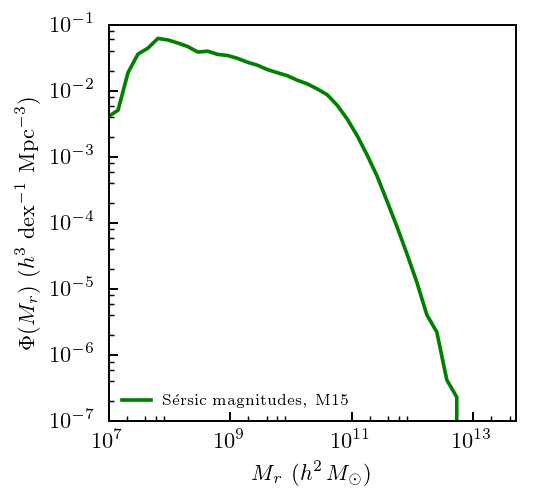

In [10]:
#
# plot LF
#
# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 40 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
phi_Mmeert, Mbins = np.histogram(logM, weights=vmaxim, bins=nbins)
# define bin centers and log widths
Mbinc = 0.5 * (Mbins[1:] + Mbins[:-1]); dMbins = (Mbins[1:]-Mbins[:-1])

# compute mean LF over a specified number of bootstrap resamplings along with error
phi_Mbsmeert, ephi_Mbsmeert = compute_lf_bootstrap(logM, vmaxim, Mbins, nbootstrap)

# rescale LF and bins to dn/dlog10(L) in units of h^3 Mpc^-3 dex^-1
phi_Mbsmeert = phi_Mbsmeert  / dMbins / cosmo.h**3
ephi_Mbsmeert = ephi_Mbsmeert  / dMbins / cosmo.h**3
Mbinc = np.log10(10.**Mbinc*cosmo.h**2)

wEll = np.abs(pEll[iloc])*vmaxiloc; wS0 = pS0[iloc]*vmaxiloc; wSab = pSab[iloc]; wScd = pScd[iloc]
Mrlim = [-24,Mlim]

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M_r\ (h^{2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(1.e7, 5e13); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Mbinc, phi_Mbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes,\ M15}$')
plt.legend(loc='lower left', fontsize=6, frameon=False)

#plt.grid()
plt.show()

The elbow of the Mass function is slightly more well-defined than the LF. Outside of that, it looks mostly the same (as expected from a simple color transformation).

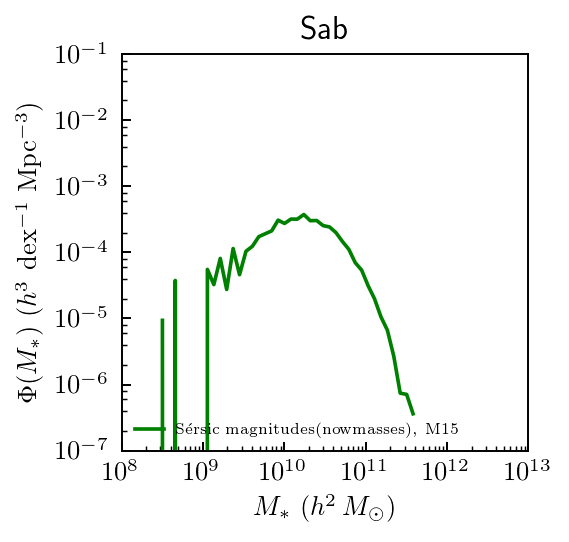

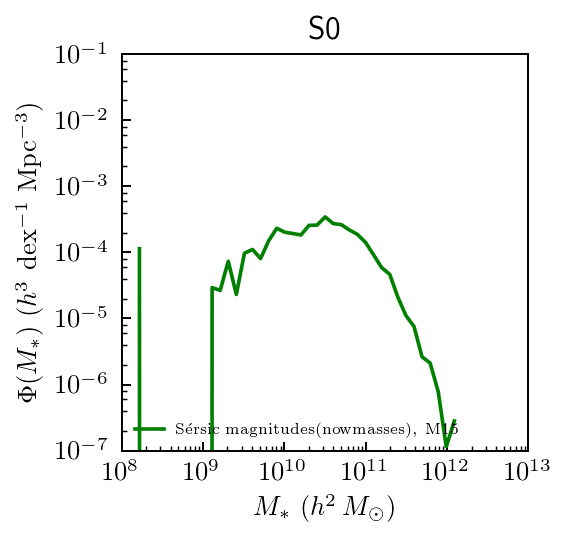

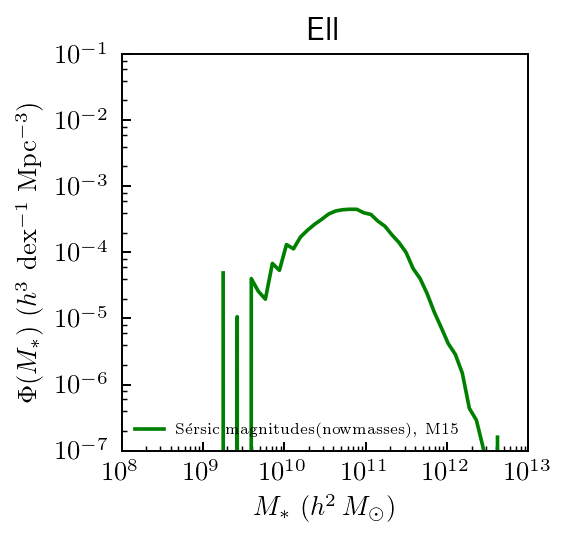

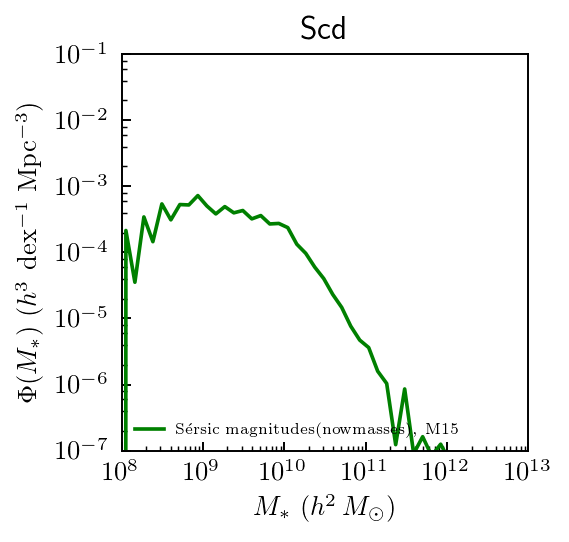

In [20]:
for galtype in galtypeslices:
    typeslice = galtypeslices[galtype]
    typelogM = logM[typeslice] 
    typevmaxim = vmaxim[typeslice]
    
    # compute mass function for all galaxies and bootstrap errors
    nbootstrap = 20; nbins = 40 # use nboostrap resamplings and estimate LF using nbins bins
    #first just get histogram without bootstrap to get bins 
    typephi_logM, typeMbins = np.histogram(typelogM, weights=typevmaxim, bins=nbins)
    # define bin centers and log widths
    typeMbinc = 0.5 * (typeMbins[1:] + typeMbins[:-1])
    typedMbins = (typeMbins[1:]-typeMbins[:-1])

    # compute mean MF over a specified number of bootstrap resamplings along with error
    typephi_Mbsmeert, typeephi_Mbsmeert = compute_lf_bootstrap(typelogM, typevmaxim, typeMbins, nbootstrap)

    # rescale MF and bins to dn/dlog10(M) in units of h^3 Mpc^-3 dex^-1
    typephi_Mbsmeert = typephi_Mbsmeert  / typedMbins / cosmo.h**3
    typeephi_Mbsmeert = typeephi_Mbsmeert  / typedMbins / cosmo.h**3
    typeMbinc = np.log10(10.**typeMbinc*cosmo.h**2)

    typeMrlim = [-24,Mlim]

    fig = plt.figure(figsize=(3, 3))
    serslabel = r'$\mathrm{{S\acute{{e}}rsic\ magnitudes (now masses),\ M15}}$'
    plt.xlabel(r'$M_*\ (h^{2}\, M_{\odot})$')
    plt.ylabel(r'$\Phi(M_*)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
    plt.xlim(1e8, 1e13); plt.ylim(1E-7, 0.1)
    plt.xscale('log'); plt.yscale('log')
    plt.rc('font',size=11)

    plt.plot(10.**typeMbinc, typephi_Mbsmeert, c='g', label = serslabel)
    plt.legend(loc='lower left', fontsize=6, frameon=False)
    plt.title('{0}'.format(galtype))
    #plt.grid()
    plt.show()

# Problem 3. GAMA Low luminosity galaxies

read 71474 GAMA galaxies
4709 galaxies left after cuts


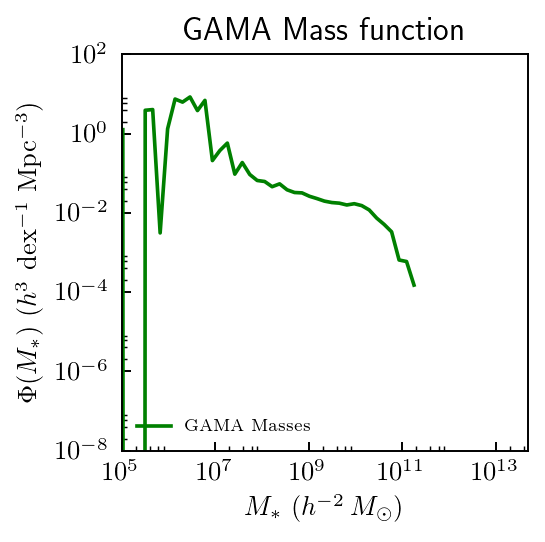

In [24]:
########################################################################
########################################################################

# SECTION 3. GAMA LOW-L STELLAR MASS FUNCTION

########################################################################
########################################################################



########################################################################

#     SUBSECTION 3.1. Read GAMA data

########################################################################


import numpy as np
from colossus.cosmology import cosmology
from code.setup import data_home_dir

def read_GAMA(fname):
    import astropy.io.fits as pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)
    
data = read_GAMA(data_home_dir()+"GAMA_DR2_full.fits")
print "read %d GAMA galaxies"%np.size(data['Z_HELIO'])

# these are conservative cuts in redshift and in magnitude
z_min = 0.001; z_max = 0.06
m_min = 10.5; m_max = 19.4

mpetro = data['PETROMAG_R']-data['EXTINCTION_R']
mg = data['GAL_MAG_G']; mi = data['GAL_MAG_I']; 
# apply magnitude and quality cuts
magslice = ( (mpetro < m_max) & (mpetro > m_min) & (mg>1.) & (mg<25.) &
            (mi>1.) & (mi<25.) )
data = data[magslice]; 
data = data[data['Z_TONRY'] > z_min]; data = data[data['Z_TONRY'] < z_max]
data = data[data['NQ'] >= 2]
print("%d galaxies left after cuts"%np.size(data))

# new sliced magnitudes
mpetro = data['PETROMAG_R'] - data['EXTINCTION_R']

# log10(M*)
logMstar = data['logmstar']
#Mstar = np.power(10.,lMstar)
zg = data['Z_HELIO']

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')
d_Lm = cosmo.luminosityDistance(zg)/cosmo.h


kcorr = data['KCORR_R']
Mpetro = mpetro - 5.0*np.log10(d_Lm/1e-5) + 1.3*zg - kcorr;

########################################################################

#     SUBSECTION 3.2. Vmax calculation

########################################################################


# vmax calculation
# maximum d_M distance to which each galaxy can be detected by the survey
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetro))/(1.+zg)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetro))/(1.+zg)
dmaxz = cosmo.luminosityDistance(z_max)/cosmo.h/(1.+zg)
d_Mmax = np.minimum(d_Mmax,dmaxz)

# compute 1/d_M^3
INVvmax = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.98 - completeness correction
cc = 0.98

skyarea = 41253. # in deg^2
skycover = 144.
fsky = skycover/skyarea
# solid angle of the sample; 
# use 0.195 as a fraction of the sky covered by the sample, as reported by Meert et al. (2015)
solid_angle = fsky * 4.*np.pi / 3.
# compute final 1/Vmax for each galaxy
INVvmax = INVvmax / (solid_angle*cc)


########################################################################

#     SUBSECTION 3.3. Compute GAMA Stellar Mass function

########################################################################


# compute mass function for all galaxies and bootstrap errors
nbootstrap = 20; nbins = 40 # use nboostrap resamplings and estimate LF using nbins bins
#first just get histogram without bootstrap to get bins 
GAMAphi_logM, GAMAMbins = np.histogram(logMstar, weights=INVvmax, bins=nbins)
# define bin centers and log widths
GAMAMbinc = 0.5 * (GAMAMbins[1:] + GAMAMbins[:-1])
GAMAdMbins = (GAMAMbins[1:]-GAMAMbins[:-1])

# compute mean MF over a specified number of bootstrap resamplings along with error
GAMAphi_Mbs, GAMAephi_Mbs = compute_lf_bootstrap(logMstar, INVvmax, GAMAMbins, nbootstrap)

# rescale MF and bins to dn/dlog10(M) in units of h^3 Mpc^-3 dex^-1
GAMAphi_Mbs = GAMAphi_Mbs  / GAMAdMbins / cosmo.h**3
GAMAephi_Mbs = GAMAephi_Mbs  / GAMAdMbins / cosmo.h**3
GAMAMbinc = np.log10(10.**GAMAMbinc*cosmo.h**2)

Mlim = -17.0
Mrlim = [-24,Mlim]


########################################################################

#     SUBSECTION 3.4. Plot GAMA mass function

########################################################################


fig = plt.figure(figsize=(3, 3))
GAMAlabel = r'$\mathrm{{ GAMA \ Masses}}$'
plt.xlabel(r'$M_*\ (h^{-2}\, M_{\odot})$')
plt.ylabel(r'$\Phi(M_{*})\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(1e5, 5e13); plt.ylim(1E-8, 1e2)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**GAMAMbinc, GAMAphi_Mbs, c='g', label = GAMAlabel)
plt.legend(loc='lower left', fontsize=7, frameon=False)
plt.title('GAMA Mass function')
#plt.grid()
plt.show()

## Problem 3b. Composite Stellar Mass Function

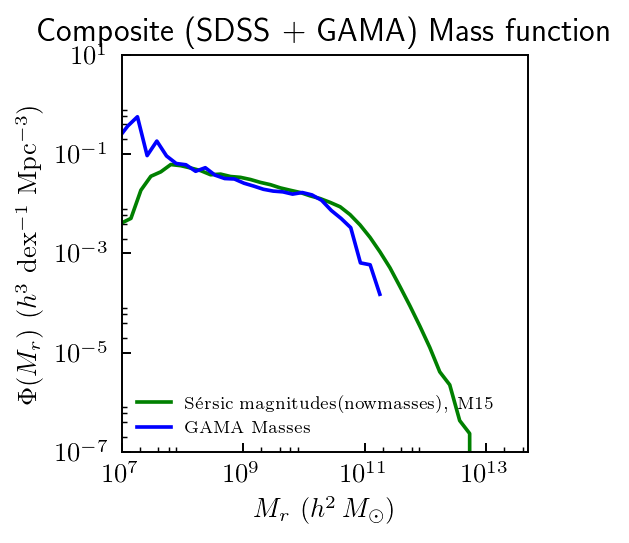

In [25]:
fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M_r\ (h^{2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M_r)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(1.e7, 5e13); plt.ylim(1E-7, 10)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Mbinc, phi_Mbsmeert, c='g', label=r'$\mathrm{S\acute{e}rsic\ magnitudes (now masses),\ M15}$')
plt.legend(loc='lower left', fontsize=6, frameon=False)


plt.plot(10.**GAMAMbinc, GAMAphi_Mbs, c='b', label = GAMAlabel)
plt.legend(loc='lower left', fontsize=7, frameon=False)
plt.title('Composite (SDSS + GAMA) Mass function')
#plt.grid()
plt.show()

#compositeLF = np.maximum(GAMAphi_Mbs, phi_Mmeert)
#plt.plot(10.**GAMAMbinc, compositeLF, c='r', label = GAMAlabel)



As I have done it here, the composite function would simply be the GAMA Mass function at all points.

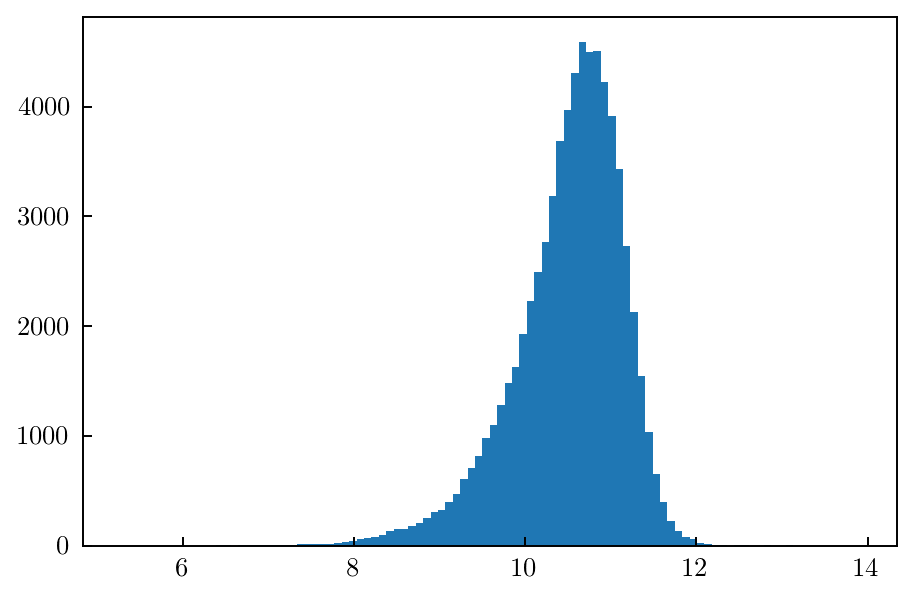

In [14]:
plt.hist(logMstar, bins = 100)
plt.show()

In [15]:
len(GAMAphi_Mbs)

40

In [16]:
import pandas as pd
import astropy.io.fits as fits

In [17]:
fpath = '/Users/thoyt/gits/classes/galaxies/hw_hoyt_taylor/data/Meert2015_v2'
fname = 'UPenn_PhotDec_Models_rband.fits'
extnum = 3

# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
with fits.open('{0}/{1}'.format(fpath, fname)) as hdulist:
    head = hdulist[0].header
    data = hdulist[extnum].data
head
data

IOError: [Errno 2] No such file or directory: '/Users/thoyt/gits/classes/galaxies/hw_hoyt_taylor/data/Meert2015_v2/UPenn_PhotDec_Models_rband.fits'

In [ ]:
Mbins

In [ ]:
plt.hist(kcorr, bins = 100)
plt.hist(zm, bins = 100)
plt.show()

In [ ]:
marksize = 1e-5
plt.scatter(zm, kcorr, s = marksize)
plt.show()